[Open this notebook on Colab](https://colab.research.google.com/github/probabll/ntmi-tutorials/blob/main/T5.ipynb)

# Guide

* Before working on this tutorial, you should have worked through the [introduction to PyTorch](https://github.com/probabll/ntmi-tutorials/blob/main/PyTorch.ipynb).
* Check the entire notebook before you get started, this gives you an idea of what lies ahead.
* Note that, as always, the notebook contains a condensed version of the theory We recommend you read the theory part before the LC session.


## ILOs

After completing this lab you should be able to

* develop NGram LMs and autoregressive LMs in Python (and PyTorch)
* estimate parameters of LMs via MLE
* evaluate LMs intrinsically in terms of perplexity
* evaluate LMs statistically in terms of properties of generated text

## General Notes

* In this notebook you are expected to use $\LaTeX$.
* Use python3.
* Use Torch
* To have GPU support run this notebook on Google Colab (you will find more instructions later).

We will use a set of standard libraries that are often used in machine learning projects. If you are running this notebook on Google Colab, all libraries should be pre-installed. If you are running this notebook locally you will need to install some additional packages, ask your TA for help if you have problems setting up.

If you need a short introduction to PyTorch [check this tutorial](https://github.com/probabll/ntmi-tutorials/blob/main/PyTorch.ipynb).


## Table of Contents




### Topics

* [Data](#sec:Data)
	* [Word segmentation and tokenisation](#sec:Word_segmentation_and_tokenisation)
	* [Data Loader](#sec:Data_Loader)
* [Language Models](#sec:Language_Models)
	* [Neural NGramLM](#sec:Neural_NGramLM)
	* [Autoregressive LM](#sec:Autoregressive_LM)
* [Evaluation](#sec:Evaluation)
* [Training](#sec:Training)
* [Demo](#sec:Demo)
* [Experiment](#sec:Experiment)


### Table of ungraded exercises

1. [Familiarise yourself with BPE tokenisation](#ungraded-1)
1. [Probability of sentence](#ungraded-2)
1. [BaseLM class](#ungraded-3)
1. [NGramLM class](#ungraded-4)
1. [AutoregressiveLM class](#ungraded-5)
1. [Training loop](#ungraded-6)


### Table of graded exercises

*Important:* The grader may re-run your notebook to investigate its correctness, but you must upload your notebook with the cells already run and make sure that all your answers are visible without the need to re-run the notebook.


Exercises have equal weights.


1. [Comparison](#graded-1)
1. [Analysis](#graded-2)

## Setting up

In [1]:
!pip install nltk
!pip install sentencepiece
!pip install tabulate

In [2]:
from collections import defaultdict
from tabulate import tabulate

import random
import numpy as np
np.random.seed(42)
random.seed(42)

<a name='sec:Data'></a>
# Data

In this tutorial we will develop models of text generation. So our data for this tutorial will be collections of sentences, or *corpora*.

To train a good language model we need _a lot_ of data. Unfortunately, we cannot learn a good language model in the time you have for a tutorial in this course. Hence, we will use a dataset that's not too large and where sentences are rather simple (so we can learn to reproduce enough of their properties with relatively little data).

We will be using a portion of the stanford natural language inference (SNLI) dataset. Sentences in this dataset are usually short and have simple syntactic structure, they typically describe a simple sitatuion (e.g., a person taking their pet on a walk).

In [3]:
import json
import numpy as np
from nltk.tokenize import word_tokenize

import os
import urllib
import zipfile


def download_snli(version='simple', SEP="[SEP]", CLS="[CLS]"):
    """
    Download the dataset from nlp.stanford.ed
    and split it into training, dev and test sets.

    :returns: a dict with three lists of sentences
        ('training', 'dev' and 'test)
        each sentence is a python string
    """
    if not os.path.isdir('snli_1.0'):
        url = "https://nlp.stanford.edu/projects/snli/snli_1.0.zip"
        print(f"Downloading SNLI dataset from {url}")
        extract_dir = "./"
        zip_path, _ = urllib.request.urlretrieve(url)
        with zipfile.ZipFile(zip_path, "r") as f:
            f.extractall(extract_dir)

    data = {
        'training': [],
        'dev': [],
        'test': []
    }
    files = {
        'training': 'snli_1.0/snli_1.0_train.jsonl',
        'dev': 'snli_1.0/snli_1.0_dev.jsonl',
        'test': 'snli_1.0/snli_1.0_test.jsonl',
    }

    for part, fname in files.items():
        for line in open(fname, 'r'):
            d = json.loads(line)
            s1 = d['sentence1']
            s2 = d['sentence2']

            if d['gold_label'] in ['contradiction', 'neutral', 'entailment']:
                if version == 'simple':
                    data[part].append(f"{s2}")
                elif version == 'control':
                    data[part].append(f"{s1} {SEP} {d['gold_label']}: {s2}")
                elif version == 'classify':
                    data[part].append(f"{s1} {SEP} {s2} {CLS} {d['gold_label']}")
                else:
                    raise ValueError(f"Unknown option: {version}")

        data[part] = np.array(data[part])

    return data

The first time we need to download the data, this may take a bit of time.

In [4]:
snli = download_snli('simple')  # do not change the version argument
print(f"Training: {snli['training'].shape}\nDev: {snli['dev'].shape}\nTest:{snli['test'].shape}")
print("Some examples from the training data:\n")
for i in range(10):
    print(snli['training'][i])

Training: (549367,)
Dev: (9842,)
Test:(9824,)
Some examples from the training data:

A person is training his horse for a competition.
A person is at a diner, ordering an omelette.
A person is outdoors, on a horse.
They are smiling at their parents
There are children present
The kids are frowning
The boy skates down the sidewalk.
The boy does a skateboarding trick.
The boy is wearing safety equipment.
An older man drinks his juice as he waits for his daughter to get off work.


We will work with two versions of this dataset: a demo version (made of only a subset of the dataset) and the complete version (which we will use in the final experiment).

In [5]:
# here we subset the dataset by selecting (at random)
#  50k sentences for training
#  500 sentences for development
#  and 1000 sentences for test
demo_training_subset = np.random.RandomState(42).choice(len(snli['training']), replace=False, size=50000)
demo_dev_subset = np.random.RandomState(42).choice(len(snli['dev']), replace=False, size=500)
demo_test_subset = np.random.RandomState(42).choice(len(snli['test']), replace=False, size=1000)
demo = {
    'training': snli['training'][demo_training_subset],
    'dev': snli['dev'][demo_dev_subset],
    'test': snli['test'][demo_test_subset],
}
len(demo['training']), len(demo['dev']), len(demo['test'])


(50000, 500, 1000)

<a name='sec:Word_segmentation_and_tokenisation'></a>
## Word segmentation and tokenisation

Our models of text generation are probability distributions over finite-length sequences of discrete symbols. These discrete symbols are what we call *tokens*. The **vocabulary** of the model is therefore the finite set of known tokens which it can use to make sequences.

We are interested in a special type of sequence, namely, sentences. Sentences are typically made of linguistic units that we call words. The linguistic notion of *word* is much too complex for our models. In practice, we use a data-driven and computationally convenient notion instead.

In this tutorial we will work with tokens that are subword units obtained via a compression algorithm known as *byte pair encoding* (BPE). From the [original paper](http://www.aclweb.org/anthology/P16-1162):
```
Byte Pair Encoding (BPE) (Gage, 1994) is a simple data compression technique that iteratively replaces the most frequent pair of bytes in a sequence with a single, unused byte. We adapt this algorithm for word segmentation. Instead of merging frequent pairs of bytes, we merge characters or character sequences.
```
You can optionally check the original paper for more detail.

We will use a package called `sentencepiece` that implements an efficient BPE tokeniser (and word segmenter) for us. This tokeniser is language independent, it learns a vocabulary of subword units from a corpus of sentences (without the need for any special annotation). Because this is based on a compression algorithm, we can choose the level of compression, that is, we can choose the number of unique symbols that we want to have in the vocabulary, the BPE algorithm will find what collection of tokens  best describes the corpus at the given budget.

After trained, we can use the BPE model to tokenise and detokenise sentences for us deterministically.

In [6]:
import sentencepiece as spm
import io

This helper function trains a BPE model for us:

In [7]:
def fit_vocabulary(corpus, vocab_size, pad_id=0, bos_id=1, eos_id=2, unk_id=3):
    """
    Return a BPE model as implemented by the sentencepiece package.

    :param corpus: an iterable of sentences, each sentence is a python string
    :param vocab_size: number of unique symbols
    :param pad_id: identifier of the special PAD symbol (for batching sequences of different length)
    :param bos_id: identifier of the special BOS symbol (which starts an input sentence)
    :param eos_id: identifier of the special EOS symbol (which ends an output sentence)
    :param unk_id: identifier of the special UNK symbol (which is used to process unseen words in the future)
    """
    proto = io.BytesIO()

    spm.SentencePieceTrainer.train(
        sentence_iterator=iter(corpus),
        model_writer=proto,
        vocab_size=vocab_size,
        pad_id=pad_id,
        bos_id=bos_id,
        eos_id=eos_id,
        unk_id=unk_id,
    )

    return spm.SentencePieceProcessor(model_proto=proto.getvalue())

Here we fit a BPE tokeniser (this could take a moment), for the demo we aim at a rather small vocabulary.

In [8]:
demo['tokenizer'] = fit_vocabulary(demo['training'], vocab_size=1000)
demo['tokenizer']

<sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type 'sentencepiece::SentencePieceProcessor *' at 0x7efbba942880> >

There are some special symbols in our vocabulary:

In [9]:
demo['tokenizer'].pad_id(), demo['tokenizer'].bos_id(), demo['tokenizer'].eos_id(), demo['tokenizer'].unk_id()

(0, 1, 2, 3)

And get to decide the vocabulary size:

In [10]:
demo['tokenizer'].vocab_size()

1000

And see how we can use this object to tokenize and detokenize text:

In [11]:
example_str = demo['training'][1]
print(example_str)

The man is outside.


The function `encode` can be used to tokenize a string into a list of tokens (each a string). To be able to read the output, you need to use the argument `out_type=str`, otherwise the tokenizer will convert the tokens to numerical codes.

In [12]:
demo['tokenizer'].encode(example_str, out_type=str)

['▁The', '▁man', '▁is', '▁outside', '.']

The `decode` method can map the tokens back to original form:

In [13]:
demo['tokenizer'].decode(demo['tokenizer'].encode(example_str, out_type=str))

'The man is outside.'

Without `out_type=str` we get a sequence of codes:

In [14]:
demo['tokenizer'].encode(example_str)

[10, 12, 6, 42, 4]

And, of course, `decode` can map it back to text:

In [15]:
demo['tokenizer'].decode(demo['tokenizer'].encode(example_str))

'The man is outside.'

There are two main advantages to this strategy for tokenization:

1. we control the vocabulary size (which helps us control memory usage)
2. oftentimes unseen words are made of a combination of existing subword units, so we can deal with more words than before

In [16]:
demo['tokenizer'].encode("This is a tutorial within Natuurlijke Talmodellen en Interfaces at the UvA.", out_type=str)

['▁Th',
 'is',
 '▁is',
 '▁a',
 '▁t',
 'ut',
 'or',
 'i',
 'al',
 '▁with',
 'in',
 '▁',
 'N',
 'at',
 'u',
 'ur',
 'li',
 'j',
 'ke',
 '▁T',
 'al',
 'm',
 'od',
 'e',
 'll',
 'en',
 '▁',
 'en',
 '▁',
 'I',
 'n',
 'ter',
 'f',
 'a',
 'ce',
 's',
 '▁at',
 '▁the',
 '▁',
 'U',
 'v',
 'A',
 '.']

In [17]:
demo['tokenizer'].encode("This is a tutorial within Natuurlijke Talmodellen en Interfaces at the UvA.")

[103,
 198,
 6,
 5,
 71,
 185,
 66,
 47,
 75,
 29,
 79,
 16,
 527,
 80,
 53,
 109,
 199,
 606,
 377,
 356,
 75,
 49,
 433,
 17,
 154,
 72,
 16,
 72,
 16,
 556,
 46,
 171,
 73,
 28,
 191,
 8,
 23,
 9,
 16,
 3,
 118,
 712,
 4]

You can also preprocess whole batches of sentences:

In [18]:
demo['tokenizer'].encode(["This is a sentence.",  "And this is another"], out_type=str)

[['▁Th', 'is', '▁is', '▁a', '▁s', 'ent', 'en', 'ce', '.'],
 ['▁An', 'd', '▁this', '▁is', '▁another']]

In [19]:
demo['tokenizer'].decode(demo['tokenizer'].encode(["This is a sentence.",  "And this is another"], out_type=str))

['This is a sentence.', 'And this is another']

<a name='ungraded-1'></a> **Ungraded Exercise 1 - Familiarise yourself with BPE tokenisation**

Play a bit with the tokenizer object.

<a name='sec:Data_Loader'></a>
## Data Loader

As we did in the PyTorch tutorial, we will create a `Dataset` object and a `DataLoader` for batching data points. In this tutorial, we batch sentences for language modelling.

The typical way to do this is to re-interpret each datapoint (a sentence `x`) as two sequences: an _input_ sequence `x_in` and an _output_ sequence `x_out`, where for any position `i` of the output sequence, the input sequence until that same position contains _past information_.

Here's an example for `x=(a, person, walking, around)`:
```
i     : 1    2       3        4        5
x_in  : BOS  a       person   walking  around
x_out : a    person  walking  around   EOS
```

See how we use BOS and EOS symbols to make sure that `x_in` and `x_out` have the same length, while making it the case that if we read the sequences from left-to-right, `x_in` is always one word behind `x_out`, this is important for a generative language model, since it conditions on historical information (relative to any one position) to predict a cpd from where, by assumption, we draw the next word.

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader


class Corpus(Dataset):
    """
    A torch dataset for language modelling.

    A common API for generative models is to imagine a sequence x as two sequences of equal length:
        x_in is a tokenized version of x, where we have BOS at the beginning;
        x_out is a tokenized version of x, where we have EOS at the end.
    Here's an example
        x = "cats, dogs and rabbits"
    becomes
        x_in  = [id(BOS),  id(cats),  id(,),     id(dogs),  id(and),      id(rabbits)]
        x_out = [id(cats), id(,),     id(dogs),  id(and),   id(rabbits),  id(EOS)]
    This way you can see that for any position i in x_out we would condition on x_in up until that same position.

    (Of course, there are other ways to code a Corpus Dataset, one could even work with a single tokenized view of x.
        We teach it this way because it's a rather common way to do it, and you will find public APIs that do the same.)
    """

    def __init__(self, corpus, tokenizer, max_length=None):
        """
        In PyTorch we better always manipulate numerical codes, rather than text.
        So, our Corpus object will contain a tokenizer that converts words to codes.

        :param corpus: a list of sentences, each a string
        :param tokenizer: a BPE tokenizer from sentencepiece
        :param max_length: if specified, we discard any sentence that's longer than max_length after tokenization
        """
        self.tokenizer = tokenizer
        if max_length is None:
            self.corpus = list(corpus)
        else:
            self.corpus = [seq for seq in corpus if len(self.tokenizer.encode(seq)) <= max_length]

    def __len__(self):
        """Number of sentences in the corpus"""
        return len(self.corpus)

    def __getitem__(self, idx):
        """
        Return an (x_in, x_out) pair made of BPE tokenized version of corpus[idx]:
            x_in is tokenized with add_bos=True
            x_out is tokenized with add_eos=True
        """
        x_in = self.tokenizer.encode(self.corpus[idx], add_bos=True)
        x_out = self.tokenizer.encode(self.corpus[idx], add_eos=True)
        return x_in, x_out

Let's see how this works:

In [21]:
demo['training_tok'] = Corpus(demo['training'], demo['tokenizer'], max_length=50)
demo['dev_tok'] = Corpus(demo['dev'], demo['tokenizer'], max_length=50)
demo['test_tok'] = Corpus(demo['test'], demo['tokenizer'], max_length=100)
print("Size of tokenized corpora:", len(demo['training_tok']), len(demo['dev_tok']), len(demo['test_tok']))

Size of tokenized corpora: 49985 500 1000


When we manipulate sequences of variable length, we need to "pad" them all to the same length. That's because to batch them using tensors they need to look like as if they did have the same length.

We do that with a special symbol that will get ignored later on.

In [22]:
def pad_to_longest(sequences, pad_id=0):
    """
    Take a list of coded sequences and returns a torch tensor where
    every sentence has the same length (by means of using PAD tokens)

    :param sequences: these are tokenized sequences of variable length
    :param pad_id: the id of the PAD symbol

    :return: batch of padded sequences
    """
    longest = max(len(x) for x in sequences)
    x = torch.tensor([x + [pad_id] * (longest - len(x)) for x in sequences])

    return x

def pad_to_longest_paired(paired_sequences, pad_id=0):
    """
    Take a list of coded sequence pairs and returns 2 torch tensors where
        every sentence has the same length (by means of using PAD tokens)

    :param paired_sequences: these are pairs of tokenized sequences of variable length
    :param pad_id: the id of the PAD symbol

    :return: batch of padded sequences x_in, batch of padded sequences x_out
    """
    seqs_in = pad_to_longest([x_in for x_in, x_out in paired_sequences])
    seqs_out = pad_to_longest([x_out for x_in, x_out in paired_sequences])
    return seqs_in, seqs_out

See what this does to the first few sentences in the batch:
- in `x_in` they will start with BOS (1) and end with as many PADs (0) as necessary
- in `x_out` they will end with EOS (2) followed by as many PADs (0) as necessary

In [23]:
pad_to_longest_paired([demo['training_tok'][0], demo['training_tok'][1], demo['training_tok'][2]])

(tensor([[  1,  10, 200,  11,  35,  13,   9, 310,   4,   0],
         [  1,  10,  12,   6,  42,   4,   0,   0,   0,   0],
         [  1,  10,  65,  85,  33, 699,   8, 592,  31,   4]]),
 tensor([[ 10, 200,  11,  35,  13,   9, 310,   4,   2,   0],
         [ 10,  12,   6,  42,   4,   2,   0,   0,   0,   0],
         [ 10,  65,  85,  33, 699,   8, 592,  31,   4,   2]]))

Now that we can convert batches of sentences to codes and guarantee they have the same length, we can construct a data loader to create mini batches at random:

In [24]:
# Let's make a dataloader with a single batch of two sentences
toy_batcher = DataLoader([demo['training_tok'][0], demo['training_tok'][1]], batch_size=2, shuffle=True, collate_fn=pad_to_longest_paired)
len(toy_batcher)

1

In [25]:
for k, (x_in, x_out) in enumerate(toy_batcher, 1):
    print(f"Input batch {k}:")
    print(x_in)
    print(f"\nOutput batch {k}:")
    print(x_out)
    print()

Input batch 1:
tensor([[  1,  10,  12,   6,  42,   4,   0,   0,   0],
        [  1,  10, 200,  11,  35,  13,   9, 310,   4]])

Output batch 1:
tensor([[ 10,  12,   6,  42,   4,   2,   0,   0,   0],
        [ 10, 200,  11,  35,  13,   9, 310,   4,   2]])



<a name='sec:Language_Models'></a>
# Language Models
    
A language model (LM) is a **probability distribution over text**, where text is a finite sequences of symbols (e.g., words or subword units).
    
LMs can be used to generate text as well as to quantify a degree of naturalness (or rather, a degree of resemblance to training data) which is useful for example to compare and rank alternative pieces of text in terms of fluency.
    
To design an LM, we need to talk about units of text (e.g., documents, paragraphs, sentences) as outcomes of a random experiment, and for that we need random variables.
    
We will generally refer to the unit of text as a *sentence*, but that's just for convenience, you could design an LM over documents and very little, if anything, would change.  

A **random sentence** is a finite sequence of symbols from the vocabulary of a given language. As a running example, we will refer to this language as English. The vocabulary of English will be denoted by $\mathcal W$, a finite collection of unique symbols, each of which we refer to as a *word* (but in practice, these symbols are any unit we care to model). We will denote a random sentence by $X$, or more explicitly, by the random sequence $X = \langle W_1, \ldots, W_L \rangle$. Here $L$ indicates the sequence length. Each word in the sequence is a random variable that takes on values in $\mathcal W$. We will adopt an important convention, every sentence is a finite sequence that ends with a special symbol, the end-of-sequence (EOS) symbol.

Formally, random sentences take on values in the set $\mathcal W^*$ of all strings made of symbols in $\mathcal W$, which is a set that does include an infinte number of valid English sentences (possibly not all English sentences, as our vocabulary may not be complete enough, but hopefully this space is still large enough for the LM to be useful) as well as an infinite number of sequences that are not valid English sentences.       
    
Part of the deal with a language model is to define and estimate a probability distribution that expresses a preference for sentences that are more likely to be accepted as English sentences. In practice an LM will prefer sentences that reproduce statistics of the observations used to estimate its parameters, whether these sentences will resemble English sentences or not will depend on how expressive the LM is, that is, whether or not the LM can capture patterns as complex as those arising from well-formed English (or whatever variant/register of English was observed during training).
    
**Notation guide** Some textbooks or papers use $W_1^L$ instead of $W_{1:L}$ for ordered sequences, both are clear enough, but we will use the notation adopted by the textbook, that is, $W_{1:L}$. The textbook uses $W_1\cdots W_L$ (without commas) as another notation for ordered sequences, but we prefer to explicitly mark the sequence with angle brackets to avoid ambiguities, i.e., we prefer $\langle W_1, \ldots, W_L \rangle$. For assignments, we will use the lowercase version of the letter that names the random variable: $w_{1:l} = \langle w_1, \ldots, w_l \rangle$.


The following notational shortcuts are rather convenient:

* we will often use $W_{1:L}$ for a random sentence instead of the longer form $\langle W_1, \ldots, W_L \rangle$, and similarly for outcomes (i.e., $w_{1:l}$ instead of $\langle w_1, \ldots, w_l\rangle$), but in the long form we shall never drop the angle brackets, as otherwise it's hard to tell that we mean an ordered sequence
* we will use $W_{<i}$ (or $w_{<i}$ for an outcome) to denote the sequence of tokens that precedes the $i$th token, this sequence is empty $W_{<i} \triangleq \langle \rangle$ for $i \le 1$, for $i>1$ the sequence is defined as $W_{<i} \triangleq \langle W_1, \ldots, W_{i-1}\rangle$
* sometimes it will be useful to find a more compact notation for $W_{<i}$, in those cases we refer to it as a *random history* and denote it by $H$.



LMs can be described by a **generative story**, that is, a stochastic procedure that explains how an outcome $w_{1:l}$ is drawn from the model distribution. Though we may find inspiration in how we believe the data were generated, the generative story is not a faithful representation of any linguistic process, it is all but an abstraction that codes our own assumptions about the problem.

The most general form this generative story can take, that is, the form with the least amount of assumptions, looks as follows:

1. For each position $i$ of a sequence, condition on the history $h_i$ and draw the $i$th word $w_i$ with probability $P(W=w_i|H=h_i)$.
2. Append $w_i$ to the end of the history: $h_i \circ \langle w_i \rangle$
2. Stop generating if $w_i$ is the EOS token, else repeat from (1).

We say this procedure is very general because it is essentially just chain rule spelled out in English words, though here the order of enumeration is determined by the left-to-right order of tokens in an English sentence.


Here is an example for a sequence of length $l=3$:

$P_X(\langle w_1, w_2, w_3 \rangle) = P_{W|H}(w_1|\langle \rangle) P_{W|H}(w_2|\langle w_1 \rangle) P_{W|H}(w_3 |\langle w_1, w_2 \rangle)$

For our example sentence *He went to the store* this means:

\begin{align}
P_X(\langle \text{He, went, to, the, store, EOS} \rangle) &= P_{W|H}(\text{He}|\langle \rangle) \\
    &\times P_{W|H}(\text{went}|\langle \text{He} \rangle) \\
    &\times P_{W|H}(\text{to}|\langle \text{He}, \text{went} \rangle) \\
    &\times P_{W|H}(\text{the}|\langle \text{He},  \text{went}, \text{to} \rangle) \\
    &\times P_{W|H}(\text{store}|\langle \text{He},  \text{went}, \text{to}, \text{the} \rangle) \\
    &\times P_{W|H}(\text{EOS}|\langle \text{He},  \text{went}, \text{to}, \text{the}, \text{store} \rangle)
\end{align}

* where with some abuse of notation we use the words themselves as outcomes instead of their corresponding indices.




<a name='ungraded-2'></a> **Ungraded Exercise 2 - Probability of sentence**

Write down the general rule for the probability $P_X$ of a sentence $w_{1:l}$. Don't forget to indicate the precise random variable associated with every distribution (that is, for example, $P_X(w_{1:l})$ and $P(X=w_{1:l})$ are correct while $P(w_{1:l})$ is incomplete).


<details>
    <summary> <b>Click to see a solution</b> </summary>

$P_X(w_{1:l}) = \prod_{i=1}^{l}P_{W|H}(w_i|w_{<i})$
    
---
    
</details>      


The LM above is just an abstraction, not a concrete implementation, think of it as a general template for building models.

A concrete model design needs to specify the conditional probability distributions in the model, this is known as the **parameterisation** of the model, and an algorithm for parameter estimation.

Next we work on a BaseLM class that captures the essence of an LM as well as on two specific parameterisations: an NGram LM and an autoregressive LM.

In [26]:
import random
import numpy as np
import torch

def seed_all(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)


seed_all()

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td
import torch.optim as opt
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

<a name='ungraded-3'></a> **Ungraded Exercise 3 - BaseLM class**

The BaseLM class below is a generic template for building neural LMs.

* It is a container for a tokenizer and an embedding layer as well as some essential LM functionality.
* It contains the general API for assigning log probability to any batch of outcomes, for computing the model's loss on a batch of observed sentences, and for drawing samples through the generative story.
* However, it lacks an implementation of the parameterisation of next-word cpds (this is something we will cover later).

Study this class.

In [28]:
class BaseLM(nn.Module):
    """
    Our BaseLM has access to a vocabulary (from a tokenizer) and an embedding layer.
    It lacks a mechanism to encode histories and to parameterise next-word cpds,
        these should be implemented in derived classes.
    """

    def __init__(self, tokenizer, embedding_dim: int, p_drop=0., w_drop=0.):
        """
        tokenizer: an already trained BPE tokenizer
        embedding_dim: dimensionality of word embeddings
        p_drop: dropout rate for regular dropout
        w_drop: dropout rate for word dropout
        """
        super().__init__()
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size()
        self.embedding_dim = embedding_dim
        self.pad = tokenizer.pad_id()
        self.bos = tokenizer.bos_id()
        self.eos = tokenizer.eos_id()
        self.unk = tokenizer.unk_id()
        self.p_drop = p_drop
        self.w_drop = w_drop
        self.embed = nn.Embedding(self.vocab_size, embedding_dim=embedding_dim)

    def device(self):
        return self.embed.weight.device

    def num_parameters(self, trainable_only=True):
        """
        Count the number of parameters in the model

        :param trainable_only: change to False to count all parameters (even those in frozen layers)
        """
        if trainable_only:
            return sum(np.prod(theta.shape) for theta in self.parameters() if theta.requires_grad)
        else:
            return sum(np.prod(theta.shape) for theta in self.parameters())

    def forward(self, x_in):
        """
        Parameterise the conditional distributions over
            X[i] given history (i.e., given x[:i]) for i=1...I.

        :param x_in: batched histories (i.e., sentences batched with add_bos=True)
            with shape [batch_size, max_length]

        :return: a batch of V-dimensional Categorical distributions, one per step of the sequence.
        """
        raise NotImplementedError("Implement me!")

    def log_prob(self, x_in, x_out):
        """
        Compute the log probability of each sentence in a batch.

        :param x_in: batched histories (i.e., sentences batched with add_bos=True)
            with shape [batch_size, max_length]
        :param x_out: batched output sequences (i.e., sentences batched with add_eos=True)
            with shape [batch_size, max_length]

        :return: a batch of log probabilities with shape [batch_size]
        """
        # The forward method returns the cpds for each step,
        #  hence, we can assess log prob of the tokens in x_out
        # [batch_size, max_length]
        logp = self(x_in).log_prob(x_out)
        # But the log prob of a sentence is the sum of the log probs of its tokens (assessed in context)
        #  (and we need to leave the PAD tokens out, since they aren't part of the text)
        # [batch_size]
        logp = torch.where(x_out != self.pad, logp, torch.zeros_like(logp)).sum(-1)
        return logp

    def sample(self, batch_size=1, max_length=50, prompt=None):
        """
        Draws a number of samples from the model, each sample is a complete sequence.
        We impose a maximum number of steps, to avoid infinite loops.
        This procedure takes care of mapping sampled symbols to pad after the EOS symbol is generated.

        :param batch_size: number of samples to draw
        :param max_length: maximum number of tokens in a sample
        :param prompt: sometimes we would like a generator to complete
            already started generations, these already started generations are called "prompts".
            For example "When I went to" is a prompt, which a model might complete as
             "When I went to the cinema last week."

            When using prompts, the sampler obtains tokens from the prompt,
                instead of actually sampling them, for as long as there
                are valid tokens in the prompt.

            To use prompts you should provide a tensor of size [batch_size, max_length]
                containing the prompt sequences. Do not use BOS and do not use EOS.
                Use PAD to pad the batch to max_length.

            Here is an example that can be used to draw 2 samples, each containing at most 10 tokens,
                the first being a completion for "a nice little" and the second being a completion for "when I":

                prompt = [
                    [id(a), id(nice), id(little)] + [id(PAD)] * 7,
                    [id(when), id(I)] + [id(PAD)] * 8,
                ]

        """
        # Sampling correctly while performing batched computations is relatively tricky,
        #  we implement a version of it here,
        #  there are more efficient versions, but they are even trickier

        # To understand the algorithm consider first study this example.

        # Example: sampling with batch_size=1 and max_length=5

        # each row below is a step in a for loop
        # x_out starts with the output shape (batch_size, max_length), but it's all PAD
        # x_in starts with BOS, then continues with tokens from x_out
        #  but only grows one token per iteration
        # at each iteration we sample a symbol *given* x_in as history
        #  that symbol goes to the corresponding cell in x_out
        # x_i is an auxiliary tensor, it has the shape of x_in
        #  but we only care about the rightmost token (the "next token" to be filled in x_out),
        #  once we have that symbol, we update x_out
        # see the example below (in the illustration, we use ? to indicate cells
        #  whose value we do not care to read):

        # x_out                 ||| x_in                  ||| x_i
        # ----------------------|||-----------------------|||---------------------
        # PAD PAD  PAD PAD PAD  ||| BOS                   ||| the
        # the PAD  PAD PAD PAD  ||| BOS the               ||| ?   cute
        # the cute PAD PAD PAD  ||| BOS the cute          ||| ?   ?    dog
        # the cute dog PAD PAD  ||| BOS the cute dog      ||| ?   ?    ?   EOS
        # the cute dog EOS PAD  ||| BOS the cute dog PAD  ||| ?   ?    ?   ?   ?

        if prompt is not None:
            batch_size = prompt.shape[0]
            if max_length > prompt.shape[1]:
                # here we extend the prompts with a bunch of PAD tokens

                # these are the missing PAD tokens
                pads = torch.full((batch_size, max_length - prompt.shape[1]), self.pad, device=self.device())
                # [batch_size, max_length]
                prompt = torch.cat([prompt, pads], -1)
            else:
                max_length = prompt.shape[1]

        # sampling discrete outcomes is not differentiable
        # but that's not a problem because we never sample during training
        # we only sample _after_ training
        with torch.no_grad():
            # Reserve memory for the samples (it's not important what symbol to use, I use PAD for clarity)
            x_out = torch.full((batch_size, max_length), self.pad, device=self.device())
            # We will be needing a batch of BOS symbols, so we can create an x_in tensor
            #  for conditioning the next-word cpds
            bos = torch.full((batch_size, 1), self.bos, device=self.device())

            # Keeps track of which samples are complete (i.e., already include EOS)
            complete = torch.zeros(batch_size, device=self.device())

            for i in range(max_length):
                # We condition on x_in and parameterise Categoricals per step
                #  then sample tokens.
                # This will sample all tokens (including tokens in the prefix),
                #  but we are only interested in the 'current' one, which we use to udpate our
                #  actual sample x_out

                # [batch_size, current_length]
                x_in = torch.cat([bos, x_out[:,:i]], 1)
                # condition on x_in and draw the x_i
                x_i = self(x_in).sample()[:, i]
                if prompt is not None:  # rather than using the sample, we force the use of the tokens in the prompt
                    x_i = torch.where(prompt[:, i] == self.pad, x_i, prompt[:, i])

                # Here we update the current token to something freshly sampled
                #  and also replace the token by 0 (pad) in case the sentence is already complete
                x_out[:, i] = x_i * (1 - complete)

                # Here we update the state of the sentence (i.e., complete or not).
                complete = (complete.bool() + (x_i == self.eos)).float()

            return x_out

    def loss(self, x_in, x_out):
        """
        Compute a scalar loss from a batch of sentences.
        The loss is the negative log likelihood of the model estimated on a single batch:
            - 1/batch_size * \sum_{s} log P(x[s]|theta)

        :param x_in: batched histories (i.e., sentences batched with add_bos=True)
            with shape [batch_size, max_length]
        :param x_out: batched output sequences (i.e., sentences batched with add_eos=True)
            with shape [batch_size, max_length]

        :returns: the average loss with shape []
        """
        # We assess the (negative) log prob of each and every batched sentence
        # [batch_size]
        loss = - self.log_prob(x_in, x_out)
        # and then return the average
        return loss.mean(0)

Later, we will need code to regularise our LMs, as we did in T4, we will use dropout and word dropout. While dropout is already supported by torch (`nn.Dropout`), word dropout needs to be implemented. Here we adapt the word dropout technique you saw in T4 slightly to avoid dropping the BOS token when it's there.

In [29]:
def word_dropout(x, pad, unk, rate=0., bos=True):  # this is a helper function we will use to specify a good encoder
    """
    Neural networks have so many parameters that they tend to overfit.
    The strategy we saw to counter overfitting in GLMs (i.e., L2 regularisation) isn't sufficient.
    A strategy that's more effective for recurrent nets is something called "word dropout",
        whereby we omit some words from the input at random. This tends to force the RNN
        to learn generalisable features.

    :param x: input sequence (batched sequences of token ids)
    :param pad: pad idx
    :param unk: unk idx
    :param rate: rate at which we omit words
        we omit a word by replacing its token id by that of the UNK token
    :param bos: if True, position 0 of each sequence is treated as a BOS symbol,
        hence, never perturbed
    :return: a perturbed version of the input x, with same shape.
    """
    if rate <= 0.:
        return x
    # 1 if valid
    vmask = (x != pad).float()
    # 1 if dropped
    rmask = (torch.rand(x.shape, device=vmask.device) < rate).float()
    # if a position is valid and should be dropped, we replace it by unk
    # else, we leave it unchanged
    x_ = torch.where(vmask + rmask == 2, torch.full_like(x, unk), x)
    if bos:
        x_[...,0] = x[...,0]
    return x_


<a name='sec:Neural_NGramLM'></a>
## Neural NGramLM

Our first stop is a historical stop. We meet the NGram LM, in particular,  [a neural NGram LM](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

Just like the classic $n$-gram LM, a neural $n$-gram LM makes a conditional independence assumption to simplify the factors in the chain rule. Rather than storying the probabilities values of observed $(h, w)$ pairs, the neural model stores the parameters necessary to predict those probabilities by transformation of the concatenation of the embeddings ofof the words in the history. The pmf of the neural $n$-gram LM is defined as follows:

\begin{align}
f(w_{1:l};\theta) &= \prod_{i=1}^l \mathrm{Cat}(w_i|\mathbf g(w_{i-n+1:i-1}; \theta))
\end{align}

where $\mathbf g$ is a neural network with parameters $\theta$, it maps a tuple of words $w_{i-n+1:i-1}$, from a vocabulary of $V$ known words, to a $V$-dimensional probability vector.

This neural network is typically implemented as follows:

* embed each word in the $i$th history into a $D$-dimensional space: $\mathbf e_j = \mathrm{embed}_D(w_j; \theta_{\text{in}})$ for $i-n + 1 \le j <i$;
* concatenate the word embeddings for the words in the $i$th history: $\mathbf u_i = \mathrm{concat}(\mathbf e_{i-n+1}, \ldots, \mathbf e_{i-1})$;
* use a single-layer feed-forward NN to transform the history encoding $\mathbf u_i$ into a vector of $V$ logits: $\mathbf s_i = \mathrm{ffnn}_V(\mathbf u_i; \theta_{\text{out}})$;
* use softmax to obtain probabilities for the possible words at the $i$th position: $\mathbf g(w_{i-n+1:i-1}; \theta) = \mathrm{softmax}(\mathbf s_i)$;
* the parameters are $\theta = \theta_{\text{in}} \cup \theta_{\text{out}}$ where
    * $\theta_{\text{in}}$ is an embedding matrix $\mathbf E \in \mathbb R^{V\times D}$;
    * $\theta_{\text{out}}$ are the parameters of the FFNN (we use 2 hidden layers): $\mathbf W^{[1]} \in \mathbb R^{H\times (n-1)D}$ and $\mathbf b^{[1]} \in \mathbb R^H$ are the parameters of the input-to-hidden layer, $\mathbf W^{[2]} \in \mathbb R^{H\times H}$ and $\mathbf b^{[2]} \in \mathbb R^H$ are the parameters of the hidden-to-hidden layer, and $\mathbf W^{[3]} \in \mathbb R^{V\times H}$ and $\mathbf b^{[3]} \in \mathbb R^V$ are the parameters of the hidden-to-output layer.


Next we implement this in PyTorch using `torch.nn.Embedding` for the embedding layer and `torch.nn.Linear` for the affine transformations inside the FFNN. As non-linearity for hidden layers we will use ReLU.

<a name='ungraded-4'></a> **Ungraded Exercise 4 - NGramLM class**

Study the NGramLM class below and complete its constructor (you need to specify the FFNN that predicts logits) and the forward method (you need to parameterise the Categorical cpds for each step). Use the tests available to check your implementation. When you are happy with it consult our solution. For exercises, use our own solution to avoid cascading errors.

In [30]:
class NGramLM(BaseLM):

    def __init__(self, tokenizer, embedding_dim: int, hidden_size: int, ngram_size: int, p_drop=0., w_drop=0.):
        """
        tokenizer: an already trained BPE tokenizer
        embedding_dim: dimensionality of word embeddings
        hidden_size: dimensionalitty of hidden layer in FFNN
        ngram_size: size of NGram
        p_drop: dropout rate for regular dropout
        w_drop: dropout rate for word dropout
        """
        super().__init__(tokenizer=tokenizer, embedding_dim=embedding_dim, p_drop=p_drop, w_drop=w_drop)
        assert ngram_size > 1, "This class expects at least ngram_size 2"
        self.ngram_size = ngram_size

        # **SOLUTION**
        self.logits_predictor = nn.Sequential(
            nn.Dropout(p_drop), # regularisation via dropout before each Linear layer
            nn.Linear((ngram_size - 1) * embedding_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_drop), # regularisation via dropout before each Linear layer
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_drop), # regularisation via dropout before each Linear layer
            nn.Linear(hidden_size, self.vocab_size),
        )

    def make_ngrams(self, x_in):
        """
        Return a batch of ngram histories for conditioning the next-word cpds.

        Example with ngram_size=3:

        x_in:
        [
            [BOS, what, a, nice, day, !  ],
            [BOS, what, a, day,  !,   PAD],
        ]

        # here the ngrams associated with x_in
        # it's also useful to remember what the corresponding
        #  x_out would be (we indicate it after '#')
        ngrams:
        [
            [
                [BOS, BOS],   # what
                [BOS, what],  # a
                [what, a],    # nice
                [a, nice],    # day
                [nice, day],  # !
                [day, !]      # EOS
            ],
            [
                [BOS, BOS],   # what
                [BOS, what],  # a
                [what, a],    # day
                [a, day],     # !
                [day, !],     # EOS
                [!, PAD]      # PAD (this position isn't real)
            ],
        ]

        :param x_in: batched histories (i.e., sentences batched with add_bos=True)
            with shape [batch_size, max_length]
        :return: batched ngram histories
            with shape [batch_size, max_length, ngram_size - 1]
        """
        x_shape = x_in.shape
        # We might need to add more BOS symbols to x_in
        # (remember, x_in already has one)
        if self.ngram_size > 2:
            # [batch_size, ngram_size - 2]
            bos = torch.full((x_in.shape[0], self.ngram_size - 2), self.bos, device=x_in.device)
            # [batch_size, max_length + ngram_size - 2]
            _x = torch.cat([bos, x_in], 1)
        else:
            _x = x_in

        # For each output step, we will have ngram_size - 1 inputs, so we collect those from x
        # [batch_size, max_length, ngram_size - 1]
        return torch.cat([_x.unsqueeze(-1)[:,i:i+self.ngram_size-1].reshape(x_shape[0], 1, -1) for i in range(x_shape[1])], 1)

    def forward(self, x_in):
        """
        Parameterise the conditional distributions over
            X[i] given history (i.e., given x[:i]) for i=1...I.

        :param x_in: batched histories (i.e., sentences batched with add_bos=True)
            with shape [batch_size, max_length]

        :return: a batch of V-dimensional Categorical distributions, one per step of the sequence.
        """
        # The inputs to the FFNN are the ngram_size-1 previous words:
        if self.training:
            x_in = word_dropout(x_in, self.pad, self.unk, self.w_drop, bos=True)

        # [batch_size, max_length, ngram_size - 1]
        inputs = self.make_ngrams(x_in)

        # *SOLUTION*
        # Embed the input histories
        # [batch_size, max_length, ngram_size - 1, D]
        e = self.embed(inputs)
        # [batch_size, max_length, (ngram_size - 1) * D]
        e = e.reshape(x_in.shape + (-1,))

        # Compute the V-dimensional scores (logits)
        # [batch_size, max_length, V]
        s = self.logits_predictor(e)

        # For numerical stability, we prefer to parameterise the Categorical using logits, rather than probs.
        # It would be equivalent (up to numerical precision) to use: Categorical(probs=F.softmax(s, -1))
        return td.Categorical(logits=s)


<details>
    <summary> <b>Click to see a solution</b> </summary>

If you double-click the cell, you will be able to copy the code:

```python

# *SOLUTION*
class NGramLM(BaseLM):

    def __init__(self, tokenizer, embedding_dim: int, hidden_size: int, ngram_size: int, p_drop=0., w_drop=0.):
        """
        tokenizer: an already trained BPE tokenizer
        embedding_dim: dimensionality of word embeddings
        hidden_size: dimensionalitty of hidden layer in FFNN
        ngram_size: size of NGram
        p_drop: dropout rate for regular dropout
        w_drop: dropout rate for word dropout
        """
        super().__init__(tokenizer=tokenizer, embedding_dim=embedding_dim, p_drop=p_drop, w_drop=w_drop)
        assert ngram_size > 1, "This class expects at least ngram_size 2"
        self.ngram_size = ngram_size

        # **SOLUTION**
        self.logits_predictor = nn.Sequential(
            nn.Dropout(p_drop), # regularisation via dropout before each Linear layer
            nn.Linear((ngram_size - 1) * embedding_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_drop), # regularisation via dropout before each Linear layer
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_drop), # regularisation via dropout before each Linear layer
            nn.Linear(hidden_size, self.vocab_size),
        )

    def make_ngrams(self, x_in):
        """
        Return a batch of ngram histories for conditioning the next-word cpds.

        Example with ngram_size=3:

        x_in:
        [
            [BOS, what, a, nice, day, !  ],
            [BOS, what, a, day,  !,   PAD],
        ]

        # here the ngrams associated with x_in
        # it's also useful to remember what the corresponding
        #  x_out would be (we indicate it after '#')
        ngrams:
        [
            [
                [BOS, BOS],   # what
                [BOS, what],  # a
                [what, a],    # nice
                [a, nice],    # day
                [nice, day],  # !
                [day, !]      # EOS
            ],
            [
                [BOS, BOS],   # what
                [BOS, what],  # a
                [what, a],    # day
                [a, day],     # !
                [day, !],     # EOS
                [!, PAD]      # PAD (this position isn't real)
            ],
        ]

        :param x_in: batched histories (i.e., sentences batched with add_bos=True)
            with shape [batch_size, max_length]
        :return: batched ngram histories
            with shape [batch_size, max_length, ngram_size - 1]
        """
        x_shape = x_in.shape
        # We might need to add more BOS symbols to x_in
        # (remember, x_in already has one)
        if self.ngram_size > 2:
            # [batch_size, ngram_size - 2]
            bos = torch.full((x_in.shape[0], self.ngram_size - 2), self.bos, device=x_in.device)
            # [batch_size, max_length + ngram_size - 2]
            _x = torch.cat([bos, x_in], 1)
        else:
            _x = x_in

        # For each output step, we will have ngram_size - 1 inputs, so we collect those from x
        # [batch_size, max_length, ngram_size - 1]
        return torch.cat([_x.unsqueeze(-1)[:,i:i+self.ngram_size-1].reshape(x_shape[0], 1, -1) for i in range(x_shape[1])], 1)

    def forward(self, x_in):
        """
        Parameterise the conditional distributions over
            X[i] given history (i.e., given x[:i]) for i=1...I.

        :param x_in: batched histories (i.e., sentences batched with add_bos=True)
            with shape [batch_size, max_length]

        :return: a batch of V-dimensional Categorical distributions, one per step of the sequence.
        """
        # The inputs to the FFNN are the ngram_size-1 previous words:
        if self.training:
            x_in = word_dropout(x_in, self.pad, self.unk, self.w_drop, bos=True)

        # [batch_size, max_length, ngram_size - 1]
        inputs = self.make_ngrams(x_in)

        # *SOLUTION*
        # Embed the input histories
        # [batch_size, max_length, ngram_size - 1, D]
        e = self.embed(inputs)
        # [batch_size, max_length, (ngram_size - 1) * D]
        e = e.reshape(x_in.shape + (-1,))

        # Compute the V-dimensional scores (logits)
        # [batch_size, max_length, V]
        s = self.logits_predictor(e)

        # For numerical stability, we prefer to parameterise the Categorical using logits, rather than probs.
        # It would be equivalent (up to numerical precision) to use: Categorical(probs=F.softmax(s, -1))
        return td.Categorical(logits=s)

```

---
    
</details>      


Let's construct a toy model for testing the implementation:

In [31]:
seed_all()
toy_ngram_lm = NGramLM(demo['tokenizer'], ngram_size=3, embedding_dim=12, hidden_size=7)
toy_ngram_lm.num_parameters()

20231

Here is a toy observation for some tests:

In [32]:
# Remember the special symbols
# PAD=0
# BOS=1
# EOS=2
# UNK=3
# These sentences aren't real, they just illustrate what a batch looks like
obs_in = torch.tensor(
    [[1, 5, 7, 6, 3, 0],
     [1, 4, 5, 7, 4, 6]]
)
obs_out = torch.tensor(
    [[5, 7, 6, 3, 2, 0],
     [4, 5, 7, 4, 6, 2]]
)
obs_in, obs_out

(tensor([[1, 5, 7, 6, 3, 0],
         [1, 4, 5, 7, 4, 6]]),
 tensor([[5, 7, 6, 3, 2, 0],
         [4, 5, 7, 4, 6, 2]]))

See what `make_ngrams` returns, this might help you understand the _forward_ method of the NGramLM class.

In [33]:
# this gives us one ngram history for each step of obs_in
toy_ngram_lm.make_ngrams(obs_in)

tensor([[[1, 1],
         [1, 5],
         [5, 7],
         [7, 6],
         [6, 3],
         [3, 0]],

        [[1, 1],
         [1, 4],
         [4, 5],
         [5, 7],
         [7, 4],
         [4, 6]]])

In [34]:
# for each history in obs_in, the forward pass gives us
# one Categorical cpd over vocab_size symbols

# as we have a batch of 2 sentences,
# each sentence has 6 tokens (including PADs)
# we have a batch of [2, 6] Categorical cpds, each cpd is 1000-dimensional
# hence logits will have shape [2, 6, 1000]
toy_ngram_lm(obs_in)

Categorical(logits: torch.Size([2, 6, 1000]))

Check that the forward pass is correct

In [35]:
assert type(toy_ngram_lm(obs_in)) is td.Categorical, "Did you change the return type?"
assert torch.allclose(torch.sum(toy_ngram_lm(obs_in).probs, -1), torch.ones_like(obs_in).float(), 1e-3), "Your probabilities do not sum to 1"
assert toy_ngram_lm(obs_in).probs.shape == obs_in.shape + (demo['tokenizer'].vocab_size(),), "The shape should be [2, 6, vocab_size]"


We can estimate the loss using the 2 observations above:

In [36]:
toy_ngram_lm.loss(obs_in, obs_out)

tensor(37.7132, grad_fn=<MeanBackward1>)

In [37]:
assert type(toy_ngram_lm.loss(obs_in, obs_out)) is torch.Tensor, "Your loss should be a torch tensor"
assert toy_ngram_lm.loss(obs_in, obs_out).requires_grad, "Your loss should be differentiable"
assert toy_ngram_lm.loss(obs_in, obs_out).shape == tuple(), "Your loss should be a scalar tensor"
assert np.isclose(toy_ngram_lm.loss(obs_in, obs_out).item(), 37, 1), "Without training, with seed 42, and the obs we gave you, your loss should be close to 37. If this is not correct, check with your TA."


We can also obtain samples from the model:

In [38]:
toy_ngram_lm.sample(5, max_length=20)

tensor([[ 56,  86, 916, 701, 940, 413, 575,  78, 654, 594, 415, 593, 452, 995,
         968, 521, 812, 705, 639, 733],
        [451, 739, 198, 925, 662, 915, 655, 111, 493, 220, 113, 310, 949, 482,
         167,  86, 313, 102, 882, 186],
        [614, 628, 816, 330, 615, 962, 307, 802, 609, 996, 960, 120, 559,  51,
         503, 458, 158, 450, 510, 516],
        [838, 404, 947, 249, 713,  99, 718, 871, 234, 580, 447, 719, 502, 146,
         570, 628, 764, 760, 637,  84],
        [600, 141, 952, 194, 586, 282, 410, 547, 118, 768,  41, 882, 230, 106,
         969, 364, 279, 385, 291, 843]])

As our model hasn't been trained to do anything in particular, the samples do not show any structure (they don't resemble the observations).

We can also sample from the model to continue some existing histories, these existing histories are called "prompts":

In [39]:
obs_prompt = torch.tensor(
    [[5, 7, 0, 0],
     [4, 5, 7, 4]
    ]
)

Without training, our prompts have no effect, and the continuations exhibit no structure whatsoever:

In [40]:
toy_ngram_lm.sample(max_length=10, prompt=obs_prompt)

tensor([[  5,   7, 488, 890,   6, 499, 739, 803, 700, 713],
        [  4,   5,   7,   4, 398, 803, 862, 377, 719, 271]])

So, let's write a training procedure (MLE).
For this toy demostration, we will overfit the model to the two observations in `obs_out`.

In [41]:
def toy_training(toy_model: BaseLM, x_in, x_out, lr=0.01, steps=1000):
    """
    Fit the model on a single batch.
    :param toy_model: an instance of BaseLM
    :param x_in: a batch of input sequences [batch_size, max_length]
        these are tokenized with add_bos=True
    :param x_out: a batch of output sequences [batch_size, max_length]
        these are tokenized with add_eos=True
    :param lr: learning rate for Adam optimizer
    :param steps: number of optimisation steps
    """
    optimiser = opt.Adam(toy_model.parameters(), lr=lr)
    with tqdm(range(steps)) as bar:
        for _ in bar:
            toy_model.train() # we need to tell torch that we are training (so dropout is enabled)
            optimiser.zero_grad() # we need to clear gradient information

            loss = toy_model.loss(x_in, x_out) # we obtain a loss
            bar.set_postfix({'loss': f"{loss:.2f}" } )

            loss.backward() # compute gradients of that loss wrt trainable parameters
            optimiser.step() # and take an optimisation step

Let's train:

In [42]:
toy_training(toy_ngram_lm, obs_in, obs_out)

  0%|          | 0/1000 [00:00<?, ?it/s]

See how sampling will now reproduce the observed sequences:

In [43]:
toy_ngram_lm.sample(5, max_length=20)

tensor([[5, 7, 4, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [5, 7, 4, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [5, 7, 4, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [4, 5, 7, 4, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [5, 7, 6, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Same is true for sampling conditionally, given a prompt:

In [44]:
toy_ngram_lm.sample(max_length=10, prompt=obs_prompt)

tensor([[5, 7, 6, 3, 2, 0, 0, 0, 0, 0],
        [4, 5, 7, 4, 6, 2, 0, 0, 0, 0]])

<a name='sec:Autoregressive_LM'></a>
## Autoregressive LM

An autoregressive LM is a parameterisation of the chain rule of probabilities, without introducing conditional independence assumptions. We make the assumption that our tokens come from a finite vocabulary and that the sequence is generated from left to right, but nothing else. This is possible because we know NN architectures that allow us to represent variable-length sequences, such as the history preceeding any one token, one such architecture is an LSTM.

\begin{align}
f(w_{1:l};\theta) &= \prod_{i=1}^l \mathrm{Cat}(w_i|\mathbf g(w_{<i}; \theta))
\end{align}

where $\mathbf g$ is a neural network with parameters $\theta$, it maps a prefix sequence $w_{<i}$ to a $V$-dimensional probability vector.

This neural network is typically implemented as follows:

* embed each word in the $i$th history into a $D$-dimensional space: $\mathbf e_j = \mathrm{embed}_D(w_j; \theta_{\text{in}})$ for $j<i$;
* for any step $i$, encode the prefix history using an LSTM generator/decoder (remember, the difference between the LSTM encoder and the LSTM decoder is that, relative to any given step, the LSTM decoder can only "see" the past): $\mathbf u_i = \mathrm{rnndec}(\mathbf u_{i-1}; \mathbf e_{i-1}; \theta_{\text{dec}})$
* predict logits for the next-token distribution: $\mathbf s_i = \mathrm{linear}_V(\mathbf u_i; \theta_{\text{out}})$;
* use softmax to obtain probabilities for the possible words at the $i$th position: $\mathbf g(w_{<i}; \theta) = \mathrm{softmax}(\mathbf s_i)$
* the parameters are $\theta = \theta_{\text{in}} \cup \theta_{\text{dec}} \cup \theta_{\text{out}}$ where
    * $\theta_{\text{in}}$ is an embedding matrix $\mathbf E \in \mathbb R^{V\times D}$
    * $\theta_{\text{dec}}$ are the LSTM parameters (proportional to $D\times H + H\times H$ for a hidden cell of size $H$ and inputs of size $D$)
    * $\theta_{\text{out}}$ are the parameters of the final output layer ($H \times V + V$)

Our architecture is loosely inspired by the [original paper](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf).



Next we implement this in PyTorch.

<a name='ungraded-5'></a> **Ungraded Exercise 5 - AutoregressiveLM class**

Study the AutoregressiveLM class below and complete its constructor (you need to specify the LSTM that encodes the history and the FFNN that predicts logits) and the forward method (you need to parameterise the Categorical cpds for each step). Use the tests available to check your implementation. When you are happy with it consult our solution. For exercises, use our own solution to avoid cascading errors.

In [45]:
class AutoregressiveLM(BaseLM):

    def __init__(self, tokenizer, embedding_dim: int, hidden_size: int, cell_size: int, num_layers=1, p_drop=0., w_drop=0.):
        """
        :param tokenizer: an already trained BPE tokenizer
        :param embedding_dim: dimensionality of word embeddings
        :param hidden_size: dimensionality of the hidden layer in FFNN
        :param cell_size: dimensionality of the LSTM cell
        :param num_layers: number of LSTM layers
        :param p_drop: dropout rate for regular dropout
        :param w_drop: dropout rate for word dropout
        """
        super().__init__(tokenizer=tokenizer, embedding_dim=embedding_dim, p_drop=p_drop, w_drop=w_drop)

        # **SOLUTION**
        self.decoder = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=cell_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=0. if num_layers == 1 else p_drop,
        )
        # **SOLUTION**
        self.logits_predictor = nn.Sequential(
            nn.Dropout(p_drop),
            nn.Linear(cell_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, self.vocab_size),
        )

    def forward(self, x_in):
        """
        Parameterise the conditional distributions over X[i] given history x[:i] for i=1...I.

        This procedure takes care that the ith output distribution conditions only on the n-1 observations before x[i].
        It also takes care of padding to the left with BOS symbols.

        x: [batch_size, max_length]

        Return: a batch of V-dimensional Categorical distributions, one per step of the sequence.
        """

        # in training mode, we apply word dropout
        if self.training:
            x_in = word_dropout(x_in, self.pad, self.unk, self.w_drop, bos=True)

        # **SOLUTION**

        # 1. we embed the tokens in x_in
        # [batch_size, max_len, emb_dim]
        e = self.embed(x_in)

        # 2. this runs the LSTM all the way to the end (even for sequences that end before the max length),
        # in the computation of the loss, however, we are careful to ignore positions that happen after EOS
        # [batch_size, max_len, hidden_size]
        v, _ = self.decoder(e)

        # 3. Compute the V-dimensional scores (logits)
        # [batch_size, max_length, V]
        s = self.logits_predictor(v)

        # 4. For numerical stability, we prefer to parameterise the Categorical using logits, rather than probs.
        # It would be equivalent (up to numerical precision) to use: Categorical(probs=F.softmax(s, -1))
        return td.Categorical(logits=s)


<details>
    <summary> <b>Click to see a solution</b> </summary>

If you double-click the cell, you will be able to copy the code:

```python

# *SOLUTION*

class AutoregressiveLM(BaseLM):

    def __init__(self, tokenizer, embedding_dim: int, hidden_size: int, cell_size: int, num_layers=1, p_drop=0., w_drop=0.):
        """
        :param tokenizer: an already trained BPE tokenizer
        :param embedding_dim: dimensionality of word embeddings
        :param hidden_size: dimensionality of the hidden layer in FFNN
        :param cell_size: dimensionality of the LSTM cell
        :param num_layers: number of LSTM layers
        :param p_drop: dropout rate for regular dropout
        :param w_drop: dropout rate for word dropout
        """
        super().__init__(tokenizer=tokenizer, embedding_dim=embedding_dim, p_drop=p_drop, w_drop=w_drop)

        # **SOLUTION**
        self.decoder = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=cell_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=0. if num_layers == 1 else p_drop,
        )
        # **SOLUTION**
        self.logits_predictor = nn.Sequential(
            nn.Dropout(p_drop),
            nn.Linear(cell_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, self.vocab_size),
        )

    def forward(self, x_in):
        """
        Parameterise the conditional distributions over X[i] given history x[:i] for i=1...I.

        This procedure takes care that the ith output distribution conditions only on the n-1 observations before x[i].
        It also takes care of padding to the left with BOS symbols.

        x: [batch_size, max_length]

        Return: a batch of V-dimensional Categorical distributions, one per step of the sequence.
        """

        # in training mode, we apply word dropout
        if self.training:
            x_in = word_dropout(x_in, self.pad, self.unk, self.w_drop, bos=True)

        # **SOLUTION**
        
        # 1. we embed the tokens in x_in
        # [batch_size, max_len, emb_dim]
        e = self.embed(x_in)
        
        # 2. this runs the LSTM all the way to the end (even for sequences that end before the max length),
        # in the computation of the loss, however, we are careful to ignore positions that happen after EOS
        # [batch_size, max_len, hidden_size]
        v, _ = self.decoder(e)

        # 3. Compute the V-dimensional scores (logits)
        # [batch_size, max_length, V]
        s = self.logits_predictor(v)

        # 4. For numerical stability, we prefer to parameterise the Categorical using logits, rather than probs.
        # It would be equivalent (up to numerical precision) to use: Categorical(probs=F.softmax(s, -1))
        return td.Categorical(logits=s)


```

---
    
</details>      


Let's construct a toy model for testing the implementation:

In [46]:
seed_all()
toy_ar_lm = AutoregressiveLM(demo['tokenizer'], embedding_dim=12, hidden_size=7, cell_size=20)
toy_ar_lm.num_parameters()

22867

See the forward pass:

In [47]:
toy_ar_lm(obs_in) # a batch of [2, 6] Categorical cpds over 1000 symbols

Categorical(logits: torch.Size([2, 6, 1000]))

Check that the forward pass is correct

In [48]:
assert type(toy_ar_lm(obs_in)) is td.Categorical, "Did you change the return type?"
assert torch.allclose(torch.sum(toy_ar_lm(obs_in).probs, -1), torch.ones_like(obs_in).float(), 1e-3), "Your probabilities do not sum to 1"
assert toy_ar_lm(obs_in).probs.shape == obs_in.shape + (demo['tokenizer'].vocab_size(),), "The shape should be [2, 6, vocab_size]"


We can estimate the loss using the 2 observations above:

In [49]:
toy_ar_lm.loss(obs_in, obs_out)

tensor(38.7100, grad_fn=<MeanBackward1>)

In [50]:
assert type(toy_ar_lm.loss(obs_in, obs_out)) is torch.Tensor, "Your loss should be a torch tensor"
assert toy_ar_lm.loss(obs_in, obs_out).requires_grad, "Your loss should be differentiable"
assert toy_ar_lm.loss(obs_in, obs_out).shape == tuple(), "Your loss should be a scalar tensor"
assert np.isclose(toy_ar_lm.loss(obs_in, obs_out).item(), 37, 1), "Without training, with seed 42, and the obs we gave you, your loss should be close to 37. If this is not correct, check with your TA."


We can also obtain samples from the model, since it's untrained the samples do not resemble the observations:

In [51]:
toy_ar_lm.sample(5, max_length=20)

tensor([[832, 922, 301,  72, 355, 267, 653, 892, 756, 136, 420, 329, 589,  52,
         221, 582, 520,   6, 228, 367],
        [420, 486, 413, 509,   3, 303, 946, 860, 593,  56, 813, 904,  38, 586,
         110,  71, 831, 187, 523, 731],
        [980, 533, 192,  80, 830, 230, 222, 824,  31, 278,  68, 618, 814, 480,
         617, 201, 965, 402, 715, 633],
        [980, 766, 822, 855, 845, 182, 873, 621, 388, 359, 121, 155, 313, 914,
         449, 901,  49, 570, 920, 574],
        [ 90, 966, 268, 986, 897, 144, 163, 243, 459, 568, 790, 873, 313, 593,
         733, 894,  63,  47, 756, 397]])

And sampling conditionally (given some prompts) shows that the prompts have no meaningful effect:

In [52]:
toy_ar_lm.sample(max_length=10, prompt=obs_prompt)

tensor([[  5,   7, 788,  51, 981, 639, 635, 135, 746,  80],
        [  4,   5,   7,   4,  80, 645, 771, 855, 612, 208]])

So, let's train the model:

In [53]:
toy_training(toy_ar_lm, obs_in, obs_out)

  0%|          | 0/1000 [00:00<?, ?it/s]

See that sampling now returns the observed structures

In [54]:
toy_ar_lm.sample(5, max_length=20)

tensor([[5, 7, 6, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [4, 5, 7, 4, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [5, 7, 6, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [4, 5, 7, 4, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [4, 5, 7, 4, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [55]:
toy_ar_lm.sample(max_length=10, prompt=obs_prompt)

tensor([[5, 7, 6, 3, 2, 0, 0, 0, 0, 0],
        [4, 5, 7, 4, 6, 2, 0, 0, 0, 0]])

<a name='sec:Evaluation'></a>
# Evaluation

There are a few ways to evaluate the performance of an LM.

Sometimes you can plug it into an application (e.g., an auto-complete system or a system that ranks sentence for fluency), in those cases we can test whether that downstream application improves as we modify the language model. This is called *extrinsic* evaluation.

To evaluate an LM independently from an application we need to evaluate its statistical properties in an attempt to determine how well the model fits the data, namely, how well it reproduces statistics of observed data. This is called *intrinsinc* evaluation. In this course, we are going to focus on intrinsic evaluation of the LM.

We generally have access to 3 datasets:

* Training is used for estimating $\theta$.
* Develpment is used to make choices during the design phase (choose hyperparameters such as smoothing technique, order of model, etc).
* Test is used for measuring the accuracy of the final model.
   
One indication of the model's fitness to the data is the value of the model likelihood given novel sentences (e.g., sentence held-out from training).
We assume this dataset $\mathcal T$ of novel sentences consits of $K$ independent sentences each denoted $w_{1:l_k}^{(k)}$, then the model likelihood given $\mathcal T$ is the probability mass that the model assigns to $\mathcal T$:

$\prod_{k=1}^K f_X(w_{1:l_k}^{(k)}; \theta)$

or in form of the log-probability:

$\sum_{k=1}^K \log f_{X}(w_{1:l_k}^{(k)}; \theta)$

Then define the log-likelihood as follows:

$\mathcal L_{\mathcal T}(\theta) = \sum_{k=1}^K \log f_X(w_{1:l_k}^{(k)}; \theta)$


Then the model that assings the higher $\mathcal L$ given the test set is the one that's better predictive of future data, presumably that's the case because it found a better fit of the training data (a better compromise between memorisation and generalisation).

In other words, given two probabilistic models, the one that assigns a higher probability to the test data is taken as intrinsically better. One detail we need to abstract away from is differences in factorisation of the models which may cause their likelihoods not to be comparable, but for that we will define *perplexity* below.

The log likelihood is used because the probability of a particular sentence according to the LM can be a very small number, and the product of these small numbers can become even smaller, and it will cause numerical
precision problems.

## Perplexity

The _perplexity_ of a language model on a test set is the inverse probability of the test set, normalized
by the number of tokens. Perplexity is a notion of average branching factor, thus an LM with low perplexity can be thought of as a *less confused* LM. That is, each time it introduces a word given some history it picks from a reduced subset of the entire vocabulary (in other words, it is more certain of how to continue from the history).

If a dataset contains $t$ tokens where $t = \sum_{k=1}^K l_k$, then the perplexity of the model given the test set is

\begin{equation}
\text{PP}_{\mathcal T}(\theta) = \exp\left( -\frac{1}{t} \mathcal L_{\mathcal T}(\theta) \right)
\end{equation}

The lower the perplexity, the better the model is. Comparisons in terms of perplexity are only fair if the models have the same vocabulary.

We will need a batched PyTorch version of perplexity, to make sure you can run experiments with the correct code, we implement it here for you:

In [56]:
def perplexity(model: BaseLM, dl: DataLoader, device=torch.device('cpu')):
    """
    model: an instance of NeuralNGramLM
    dl: a data loader for the heldout data
    device: the PyTorch device where the model is stored
    """
    model.eval() # we tell torch that we are in evaluation mode (so, for example, dropout is disabled)
    total_tokens = 0 # needed for perplexity
    total_log_prob = 0.
    with torch.no_grad():  # we don't need gradients in evaluation
        for x_in, x_out in dl:
            total_tokens += (x_out > 0).float().sum()
            total_log_prob = total_log_prob + model.log_prob(x_in=x_in.to(device), x_out=x_out.to(device)).sum()
    return torch.exp(-total_log_prob / total_tokens)

<a name='sec:Training'></a>
# Training

We now implement a complete training loop for our demo.
This time, rather than overfitting to 2 made up observations, we want to use a DataLoader that iterates over our tokenized datasets.

The _demo_ runs on CPU (each model will take about 5 minutes), but the demo will not lead to a model that produces reasonable sentences. The actual experiment using the complete SNLI dataset cannot be done on CPU, so we suggest you use Google Colab. For developing your code, you can use the demo (and you can make it even smaller if you like), but for the final experiment, please use the complete SNLI dataloader.

In [57]:
if torch.cuda.is_available():
    my_device = torch.device('cuda:0')
else:
    my_device = torch.device('cpu')
    print("You may continue with CPU, but when you get to the final experiment a CPU will be much too slow.")
my_device

device(type='cuda', index=0)

<a name='ungraded-6'></a> **Ungraded Exercise 6 - Training loop**

Study the training loop below.

In [58]:
import os

def train_neural_model(exp_name: str, model: BaseLM, optimizer, training_corpus: Corpus, dev_corpus: Corpus, batch_size=200, num_epochs=10, check_every=100, device=torch.device('cuda:0'), ckptdir="checkpoints"):
    """
    :param exp_name: filename to save the model
    :param model: an instance of BaseLM
    :param optimizer: a torch optimizer, we suggest Adam
    :param training_corpus: tokenized training data (an instance of Corpus)
    :param dev_corpus: tokenized dev/validation data (an instance of Corpus)
    :param batch_size: number of sentences in a single batch
    :param num_epochs: number of passes over the entire training corpus
    :param check_every: number of steps between validation checks
    :param device: torch device where the model is
    :param ckptdir: directory to save models
    :returns: training log as a dictionary of measurements such as
        - training loss
        - dev perplexity
    """
    if not os.path.exists(ckptdir):  # we will be storing models in this folder
        os.makedirs(ckptdir)
    # we use the training data in random order for parameter estimation
    batcher = DataLoader(training_corpus, batch_size=batch_size, shuffle=True, collate_fn=pad_to_longest_paired)
    # we use the dev data for evaluation during training (no need for randomisation here)
    dev_batcher = DataLoader(dev_corpus, batch_size=batch_size, shuffle=False, collate_fn=pad_to_longest_paired)

    total_steps = num_epochs * len(batcher)
    log = defaultdict(list)
    ppl = perplexity(model, dev_batcher, device=device).item()
    log['ppl'].append(ppl)
    best_ppl = ppl
    torch.save(model.state_dict(), f"{ckptdir}/{exp_name}.pt")
    step = 0

    with tqdm(range(total_steps)) as bar:
        for epoch in range(num_epochs):

            for x_in, x_out in batcher:
                model.train()  # this is how pytorch knows that we will be updating parameters
                optimizer.zero_grad()  # this is needed in order to reset gradient information from previous iterations

                loss = model.loss(x_in.to(device), x_out.to(device))  # compute the loss for this batch

                loss.backward()  # compute the gradient with respect to the parameters using backpropagation
                optimizer.step()  # take a step towards minimising the loss

                # udpate logging info
                bar.set_postfix({'loss': f"{loss.item():.2f}", 'ppl': f"{ppl:.2f}"})
                bar.update()
                log['loss'].append(loss.item())

                if step % check_every == 0:  # every so often, check performance on validation set
                    ppl = perplexity(model, dev_batcher, device=device).item()
                    log['ppl'].append(ppl)
                    if ppl <= best_ppl: # save a better checkpoint
                        best_ppl = ppl
                        torch.save(model.state_dict(), f"{ckptdir}/{exp_name}.pt")

                step += 1

    ppl = perplexity(model, dev_batcher, device=device).item()
    if ppl <= best_ppl: # save a better checkpoint
        best_ppl = ppl
        torch.save(model.state_dict(), f"{ckptdir}/{exp_name}.pt")
    log['ppl'].append(ppl)
    return log

<a name='sec:Demo'></a>
# Demo

Here we demonstrate how to train and evaluate a model.
First, some helper code.


In [59]:
def plot_loss_and_ppl(log, skip=3):
    """
    :param log: dict with loss measurements and ppl measurements
    :param skip: skip the first few ppl measurements
        the ppl of the untrained model is so high
        that it's more insightful not to plot it
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    _ = axs[0].plot(np.arange(len(log['loss'])), log['loss'])
    _ = axs[0].set_xlabel('steps')
    _ = axs[0].set_ylabel('training loss')
    _ = axs[1].plot(np.arange(len(log['ppl'][skip:])), log['ppl'][skip:])
    _ = axs[1].set_xlabel('steps (in 100s)')
    _ = axs[1].set_ylabel('model ppl given dev')
    _ = fig.tight_layout(h_pad=2, w_pad=2)
    plt.show()


In [60]:
def print_few_samples(model, num_samples, max_length=50):
    """
    :param model: an instance of BaseLM
    :param num_samples: number of samples (these will be drawn in a single batch)
    :param max_length: longest sample
    """
    for i, x in enumerate(model.tokenizer.decode(model.sample(num_samples, max_length).tolist(), out_type=str), 1):
        print(f"{i}\t{x}")

In [61]:
def print_few_prompted_samples(model, prompt_strings=['A person', 'A person walking', 'A person selling their'], num_samples=5, max_length=50):
    """
    :param model: an instance of BaseLM
    :param prompt_strings: a list of prompts (each a string)
    :param num_samples: how many times we will complete the prompts by sampling from the model
    :param max_length: longest sample
    """
    prompt_batch = pad_to_longest(
        model.tokenizer.encode(prompt_strings),
        model.tokenizer.pad_id()
    ).to(model.device())

    for k in range(num_samples):
        print(f"\nExperiment {k+1}\n")
        for i, x in enumerate(model.tokenizer.decode(model.sample(max_length=max_length, prompt=prompt_batch).tolist(), out_type=str)):
            print(f"{prompt_strings[i]} ||| {x}")


**NGramLM**

On CPU this should take about 2 minutes.

Model
NGramLM(
  (embed): Embedding(1000, 32)
  (logits_predictor): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=64, out_features=1000, bias=True)
  )
)
NGramLM model size: 105320


  0%|          | 0/2500 [00:00<?, ?it/s]

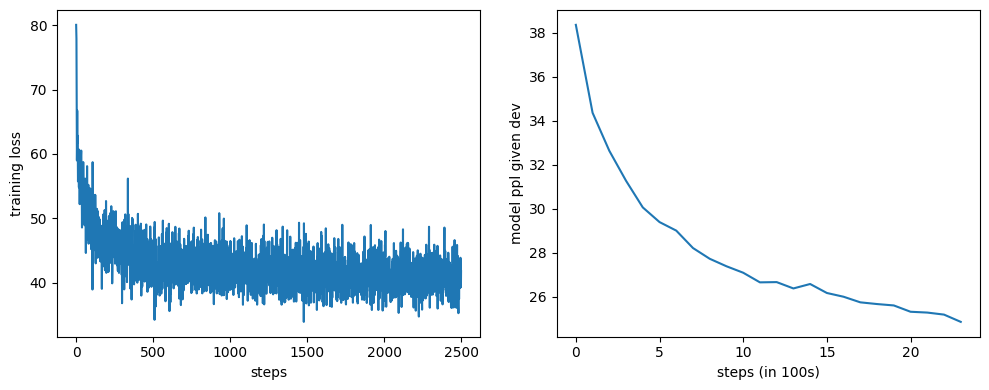



 Model perplexity given test set 25.44707679748535

# Samples


1	People are coals are playing stack.
2	Some people are playing in front of a line is being is skateboarding is resting
3	A guy is in front of a coat goods a kick outside.
4	Some people takeed chagly outdoors.
5	Children are outside
6	The woman does karate in bed.
7	The little woman throwing a tour nothing in an emptyly Pordy to get the bicycle ones.
8	A little boy is wearing friends at a father.
9	Someone is getting a dog rider is jumping giving kids party on horse.
10	The woman is watching teminting.

# Prompted samples



Experiment 1

A person ||| A person wearing scridest pants with newspapers.
A person walking ||| A person walking drums.
A person selling their ||| A person selling their froza comel record up ready to get shaded to the TV goingrys.

Experiment 2

A person ||| A person is wearing unup.
A person walking ||| A person walking.
A person selling their ||| A person selling their picture is having a bat con

In [62]:
%%time
seed_all() # reset random number generators before creating your model and training it

demo['model.ngram'] = NGramLM(
    demo['tokenizer'],
    embedding_dim=32,
    hidden_size=64,
    ngram_size=3,
    p_drop=0.1
).to(my_device)

print("Model")
print(demo['model.ngram'])
# report number of parameters
print("NGramLM model size:", demo['model.ngram'].num_parameters())

demo['log.ngram'] = train_neural_model(
    "3gram",
    demo['model.ngram'],
    opt.Adam(demo['model.ngram'].parameters(), lr=1e-2),
    demo['training_tok'],
    demo['dev_tok'],
    batch_size=100,
    num_epochs=5,
    check_every=100,
    device=my_device
)

plot_loss_and_ppl(demo['log.ngram'])

test_ppl = perplexity(
    demo['model.ngram'],
    DataLoader(
        demo['test_tok'],
        batch_size=100,
        shuffle=False,
        collate_fn=pad_to_longest_paired
    ),
    device=my_device
)
print("\n\n Model perplexity given test set", test_ppl.item())

print("\n# Samples\n\n")
print_few_samples(demo['model.ngram'], 10)

print("\n# Prompted samples\n\n")
print_few_prompted_samples(demo['model.ngram'])


**AutoregressiveLM**

On CPU this should take about 2 minutes.

Model
AutoregressiveLM(
  (embed): Embedding(1000, 32)
  (decoder): LSTM(32, 64, batch_first=True)
  (logits_predictor): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=64, out_features=1000, bias=True)
  )
)
Autoregressive model size: 126248


  0%|          | 0/2500 [00:00<?, ?it/s]

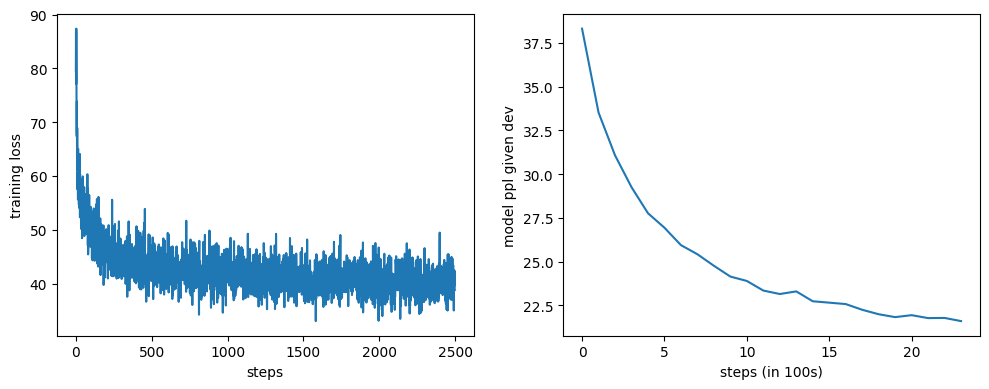



 Model perplexity given test set 22.13698387145996

# Samples


1	Two men playing with her leg with the paper.
2	Somequer does photos cants on a finople outside
3	Two people are sitting.
4	She looks out a gay.
5	The men eat in a pate.
6	A man in bluedit and several catch is grilling secue on the sidewalk.
7	A girl is taking a bath for a museum.
8	A photographer is made with a man in camil sit together whamage.
9	A man is working around a poloman
10	K friendsin in the country, sitting.

# Prompted samples



Experiment 1

A person ||| A person in the Ooder is outside.
A person walking ||| A person walking in the mallgoldrot flags traffic.
A person selling their ||| A person selling their people are reading a blue music inside homeed dum.

Experiment 2

A person ||| A person and another child dancing
A person walking ||| A person walking with something in her bed.
A person selling their ||| A person selling their home.

Experiment 3

A person ||| A person and a child are having lunch w

In [63]:
%%time
seed_all() # reset random number generators before creating your model and training it

demo['model.lstm'] = AutoregressiveLM(
    demo['tokenizer'],
    embedding_dim=32,
    hidden_size=64,
    cell_size=64,
    num_layers=1,
    w_drop=0.1,
    p_drop=0.1
).to(my_device)

print("Model")
print(demo['model.lstm'])
# report number of parameters
print("Autoregressive model size:", demo['model.lstm'].num_parameters())

demo['log.lstm'] = train_neural_model(
    "lstm",
    demo['model.lstm'],
    opt.Adam(demo['model.lstm'].parameters(), lr=1e-2),
    demo['training_tok'],
    demo['dev_tok'],
    batch_size=100,
    num_epochs=5,
    check_every=100,
    device=my_device
)

plot_loss_and_ppl(demo['log.lstm'])

test_ppl = perplexity(
    demo['model.lstm'],
    DataLoader(
        demo['test_tok'],
        batch_size=100,
        shuffle=False,
        collate_fn=pad_to_longest_paired
    ),
    device=my_device
)
print("\n\n Model perplexity given test set", test_ppl.item())

print("\n# Samples\n\n")
print_few_samples(demo['model.lstm'], 10)

print("\n# Prompted samples\n\n")
print_few_prompted_samples(demo['model.lstm'])



<a name='sec:Experiment'></a>
# Experiment

The next two experiments will use a larger version of the dataset and larger models. Because of that, they are too slow on CPU, hence we recommend you use Colab.

If for some reason you are unable to use Colab, it's okay to perform the two experiments using the dataset, tokenizer and models you trained in the `demo` above, though the results will be less interesting to analyse.

In [64]:
if not torch.cuda.is_available():
    raise ValueError("The next experiment is probably too slow on CPU.")

This is the dataset and tokenizer for the following two experiments/exercises:

In [65]:
snli['tokenizer'] = fit_vocabulary(snli['training'], vocab_size=10000)
snli['training_tok'] = Corpus(snli['training'], snli['tokenizer'], max_length=50)
snli_dev_subset = np.random.RandomState(42).choice(len(snli['dev']), replace=False, size=2000)
snli['dev_tok'] = Corpus(snli['dev'][snli_dev_subset], snli['tokenizer'], max_length=50)
snli['test_tok'] = Corpus(snli['test'], snli['tokenizer'])
len(snli['training_tok']), len(snli['dev_tok']), len(snli['test_tok'])

(549357, 2000, 9824)

<a name='graded-1'> **Graded Exercise 1 - Comparison** </a>

On GPU, train the following two models using the specified hyper-parameters.

```python
snli['model.ngram'] = NGramLM(
    snli['tokenizer'],
    embedding_dim=100,
    hidden_size=128,
    ngram_size=3,  
    p_drop=0.1
).to(my_device)

# and

snli['model.lstm'] = AutoregressiveLM(
    snli['tokenizer'],
    embedding_dim=100,
    hidden_size=128,
    cell_size=128,
    num_layers=1,
    w_drop=0.1,
    p_drop=0.1
).to(my_device)
```

Use
* `lr=1e-2`
* `batch_size=500`
* `num_epochs=2`
* `check_every=100`



Then,

1. Plot training loss and validation perplexity. Do you observe overfitting?
2. Report perplexity given the `test` set. Which model performs best on this criterion?
3. Obtain 20 samples from each model, decode them back to strings and print them. Analyse the samples manually and make remarks about their quality (or lack of quality), try to ground observations you make to technical aspects of your model.
4. Prompt the model with at least the provided prompts (feel free to test more prompts if you like). Obtain 5 samples for each prompt (you can basically prompt the model 5 times with the same batch of prompts). Do you observe meaningful differences between the two models?

  0%|          | 0/2198 [00:00<?, ?it/s]

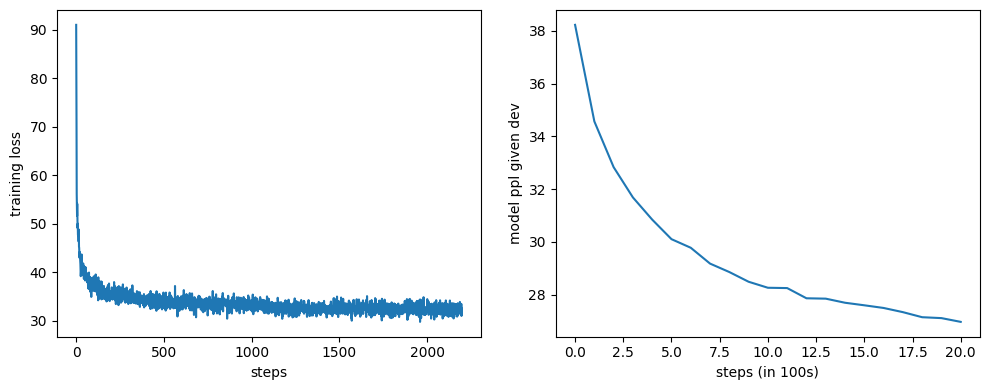



 Model perplexity given test set 27.691526412963867

# Decoded NGram Samples

1	The man is outside.
2	The kid has some pockets.
3	A girl sits by some warmth.
4	a woman is in a grassy country.
5	Two men were both on stage.
6	The gun is going swimming the crossing wall is on it, over an event at the skate park.
7	A man catches a milkshake
8	A man is working.
9	The man has a umbrella.
10	The workers are holding a briefcase pile their brooms towards a drink to be photographed while another man.
11	Three women and man are recieving from a void of goats dressed.
12	The little boy is throwing another at the public parallel over nothing.
13	man is trying to catch a rally.
14	A person has graffiti in Africa
15	There is no animals.
16	Three ladies are outside.
17	There are at a house.
18	A person standing under water.
19	A man walks down a fence.
20	A drummer is performing with a Cons.

# Decoded NGram Prompted Samples


Experiment 1

A person ||| A person doing an advancebar.
A person walking

In [66]:
snli['model.ngram'] = NGramLM(
    snli['tokenizer'],
    embedding_dim=100,
    hidden_size=128,
    ngram_size=3,
    p_drop=0.1
).to(my_device)

snli['log.ngram'] = train_neural_model(
    "ngram",
    snli['model.ngram'],
    opt.Adam(snli['model.ngram'].parameters(), lr=1e-2),
    snli['training_tok'],
    snli['dev_tok'],
    batch_size=500,
    num_epochs=2,
    check_every=100,
    device=my_device
)

plot_loss_and_ppl(snli['log.ngram'])

test_ppl = perplexity(
    snli['model.ngram'],
    DataLoader(
        snli['test_tok'],
        batch_size=100,
        shuffle=False,
        collate_fn=pad_to_longest_paired
    ),
    device=my_device
)

print("\n\n Model perplexity given test set", test_ppl.item())

print("\n# Decoded NGram Samples\n")
num_samples = 20
print_few_samples(snli['model.ngram'], num_samples)

print("\n# Decoded NGram Prompted Samples\n")
print_few_prompted_samples(snli['model.ngram'])



  0%|          | 0/2198 [00:00<?, ?it/s]

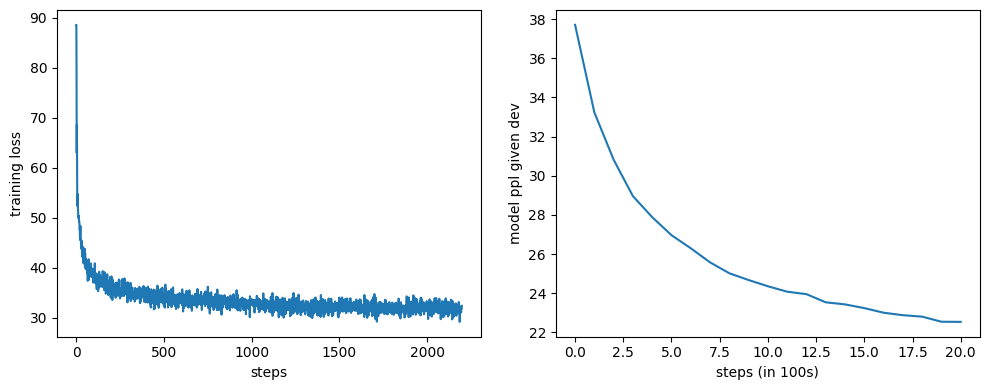



 Model perplexity given test set 23.128278732299805

# Decoded NGram Samples

1	Two player feeds another dellior balls.
2	Three women are scavenging by the firetruck.
3	A young person is preparing.
4	The man is inside a building.
5	The couple is watching a band together and other men cleaned.
6	The man is sitting in his bed.
7	Children riding bicycle while both ice skating.
8	A person is grilling donuts
9	It is raining.
10	A toy is getting ready to land.
11	the man rides the transportation through a pasture.
12	Horses who are instruments.
13	collection of peoples conference
14	There is empty project.
15	A girl wants to destroy her body of with of dolls.
16	A girl plays drums.
17	cat eats lunch
18	A mime is outdoors with others along the field.
19	Two generations aren't girls brown.
20	is sitting decorated one has a pancake toy as another playing golf with some people.

# Decoded NGram Prompted Samples


Experiment 1

A person ||| A person is lookingin.
A person walking ||| A person w

In [67]:
snli['model.lstm'] = AutoregressiveLM(
    snli['tokenizer'],
    embedding_dim=100,
    hidden_size=128,
    cell_size=128,
    num_layers=1,
    w_drop=0.1,
    p_drop=0.1
).to(my_device)

snli['log.lstm'] = train_neural_model(
    "lstm",
    snli['model.lstm'],
    opt.Adam(snli['model.lstm'].parameters(), lr=1e-2),
    snli['training_tok'],
    snli['dev_tok'],
    batch_size=500,
    num_epochs=2,
    check_every=100,
    device=my_device
)

plot_loss_and_ppl(snli['log.lstm'])

test_ppl = perplexity(
    snli['model.lstm'],
    DataLoader(
        snli['test_tok'],
        batch_size=100,
        shuffle=False,
        collate_fn=pad_to_longest_paired
    ),
    device=my_device
)

print("\n\n Model perplexity given test set", test_ppl.item())

print("\n# Decoded LSTM Samples\n")
num_samples = 20
print_few_samples(snli['model.lstm'], num_samples)

print("\n# Decoded LSTM Prompted Samples\n")
print_few_prompted_samples(snli['model.lstm'])



1. For both models, there is no observable overfitting. The training loss decreases over time, and the perplexity on the dev set also decreases. This suggests that the models are generalizing well to the unseen dat ain the dev set. If there was overfitting, we would see that the training loss would continue to drop while the dev perplexity stagnates or increases.
2.

<a name='graded-2'> **Graded Exercise 2 - Analysis** </a>

Last, conduct a statistical evaluation of the two models.
For this, for each model, you should:
1. Draw as many samples as you have sentences in the dev set. Your samples should be obtained without prompts. Be careful, if you try to draw all samples in a single batch, you will run out of memory (instead, you should draw many batches of some reasonable size).
2. Compare the distribution of the length of the observed sentences in the dev set to the distribution of the length of the sentences generated in step (1). For this comparison, compute length in number of BPEs (and make sure to not count PAD). Use an appropriate data visualisation tool for this. Make remarks about what you see.
3. Now, tokenize the sentences you generated in (1) using NLTK's `word_tokenize` (as this will give you symbols that are more similar to linguistic words than BPE tokenization does). Similarly, tokenize the sentences in the **training** data using `word_tokenize`. Investigate what percentage of generated words did not exist in the training data. Finally, inspect a subset of these novel symbols (concentrate on the 30 most frequent such symbols). Comment on what you observe (e.g., are they English words, are they gibberish?).


Last, but not least, compare your findings for step (2) and (3) across models. What do you notice? Do you notice any effect of conditional independences (or lack thereof) in your findings?

In [68]:
# CONTRIBUTE YOUR SOLUTION/CODE

	CONTRIBUTE YOUR SOLUTION/DISCUSSION

---